# Imports

In [1]:
from collections import Counter

import pandas as pd

from loader import read_obsmat, read_groups

# Load data

In [2]:
dataset_path = './ETH/seq_eth'
df = read_obsmat(dataset_path)
groups = read_groups(dataset_path)

In [3]:
df.head()

,frame_id,agent_id,pos_x,pos_y,v_x,v_y,timestamp
0,780,1,8.456844,3.588066,1.671714,0.176292,52.0
1,786,1,9.125530,3.658583,1.662877,0.326723,52.4
2,792,1,9.787146,3.849445,1.683334,0.371084,52.8
3,798,1,10.472197,3.955450,1.598568,0.264795,53.2
4,804,1,11.066000,4.061280,1.574526,0.456390,53.6


<AxesSubplot:title={'center':'eth'}>

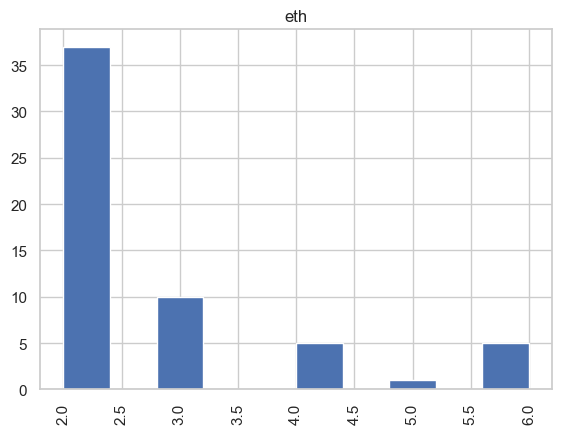

In [43]:
groups_len = [len(group) for group in groups]
groups_df = pd.DataFrame(groups_len, columns=['len'])
groups_df['dataset'] = 'eth'
groups_df.hist(by='dataset')

In [36]:
duration = df.loc[df.frame_id.idxmax()]['timestamp'] - df.loc[df.frame_id.idxmin()]['timestamp']
print('Duration: {}s'.format(duration))

Duration: 773.4s


In [27]:
print('Shape of dataframe: {}'.format(df.shape))
print('Number of unique agents: {}'.format(df.agent_id.unique().size))
print('Number of unique frames: {}'.format(df.frame_id.unique().size))

Shape of dataframe: (8908, 7)
Number of unique agents: 360
Number of unique frames: 1448


In [19]:
print('Number of groups: {}'.format(len(groups)))

count_dict = Counter([agent for group in groups for agent in group])
multigroup_agents = [key for key, value in count_dict.items() if value > 1]
print('Agents {} are found in more than one group'.format(multigroup_agents))

group_agents = [agent for agent in count_dict.elements()]
print('Number of agents in groups: {}'.format(len(group_agents)))

Number of groups: 61
Agents ['238', '241', '242', '320', '321', '322', '323'] are found in more than one group
Number of agents in groups: 167


number of frames for each agent

In [15]:
df['agent_id'].value_counts()

468    539
473    539
233    288
232    287
228    263
      ... 
407      6
369      6
299      5
298      5
408      2
Name: agent_id, Length: 428, dtype: int64

number of people for each frame

In [10]:
df['frame_id'].value_counts()

10383    27
10437    26
10377    26
10365    26
10371    26
         ..
4625      1
8703      1
8679      1
4577      1
1950      1
Name: frame_id, Length: 1448, dtype: int64

In [22]:
from loader import load_eth

In [23]:
eth_traj_dataset = load_eth('./ETH/seq_eth/obsmat.txt')
eth_trajs = eth_traj_dataset.get_trajectories()

In [25]:
eth_traj_dataset.data.iloc[eth_trajs.groups[0, 1]]  # get trajectory of scene_id 0 and pedestrian_id 1

,frame_id,agent_id,pos_x,pos_y,vel_x,vel_y,scene_id,label,timestamp
0,780,1,8.456844,3.588066,1.671714,0.176292,0,pedestrian,52.0
1,786,1,9.125530,3.658583,1.662877,0.326723,0,pedestrian,52.4
2,792,1,9.787146,3.849445,1.683334,0.371084,0,pedestrian,52.8
3,798,1,10.472197,3.955450,1.598568,0.264795,0,pedestrian,53.2
4,804,1,11.066000,4.061280,1.574526,0.456390,0,pedestrian,53.6
6,810,1,11.731818,4.320563,1.644127,0.544391,0,pedestrian,54.0
8,816,1,12.381302,4.496793,1.623709,0.440576,0,pedestrian,54.4


In [26]:
eth_traj_dataset.data[eth_traj_dataset.data['agent_id'] == 1]

,frame_id,agent_id,pos_x,pos_y,vel_x,vel_y,scene_id,label,timestamp
0,780,1,8.456844,3.588066,1.671714,0.176292,0,pedestrian,52.0
1,786,1,9.125530,3.658583,1.662877,0.326723,0,pedestrian,52.4
2,792,1,9.787146,3.849445,1.683334,0.371084,0,pedestrian,52.8
3,798,1,10.472197,3.955450,1.598568,0.264795,0,pedestrian,53.2
4,804,1,11.066000,4.061280,1.574526,0.456390,0,pedestrian,53.6
6,810,1,11.731818,4.320563,1.644127,0.544391,0,pedestrian,54.0
8,816,1,12.381302,4.496793,1.623709,0.440576,0,pedestrian,54.4


In [27]:
eth_traj_dataset.data.shape

(8908, 9)

# Thoughts and TODOs

goal: data for all agents, both in or not in groups
problems: agents in low number of frames

number of same agents in X consecutive frames

In [13]:
# TODO calculate number of same agents in all possible X consecutive frames, find set of agents in each frame, check intersection between the sets

agents that exist in low number of frames

In [20]:
# TODO for agents with lower than X frames, generate data to reach X frames

time window 1 frame

In [ ]:
# TODO check number of data when time window is 1 frame

agents in multiple groups

In [ ]:
# TODO check number of agents in multiple groups